In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# !pip install peft bitsandbytes -q
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from open_pref_eval.datasets import get_default_datasets
from open_pref_eval.evaluation import evaluate_models, evaluate_model, evaluate
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import torch
from transformers import BitsAndBytesConfig
from tqdm.auto import tqdm
from anycache import anycache
from open_pref_eval.plot.radar import radar_plot
from open_pref_eval.helpers.mem import clear_mem


quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

In [ ]:
datasets = get_default_datasets(450)
datasets

In [ ]:
models = [
    'snake7gun/tiny-random-qwen3',
    "Qwen/Qwen3-1.7B",
    "Qwen/Qwen3-4B",
    "Qwen/Qwen3-8B",
    "unsloth/Qwen3-14B",
    "microsoft/Phi-4-mini-instruct", # 4b
    "soob3123/amoral-gemma3-4B-v2",
    "unsloth/gemma-3-4b-it",
    
    # "mlabonne/Qwen3-4B-abliterated",
    # "unsloth/Qwen3-4B",
    "wassname/qwen-7B-codefourchan",
    "opencompass/CompassJudger-1-7B-Instruct",




    # "unsloth/gemma-2-9b-it",
    # 'google/gemma-2-2b',
    # "CohereLabs/c4ai-command-r7b-12-2024",
    # 'emergent-misalignment/Qwen-Coder-Insecure',
    # "drfellx/emergent_misalignment_test_qwen2.5-7B-Instruct",
    # "dpasch01/pp-llama3-8b-right-wing",
    # "dpasch01/pp-llama3-8b-left-wing",
    # "unsloth/DeepSeek-R1-Distill-Qwen-7B"
]

In [ ]:
from open_pref_eval.scoring import first_nonzero, score_1st_diverg, score_preferences, score_ipo, score_cumsum, score_weighted, score_weighted_prob, score_with_entropy_weight, score_f_alpha_divergance, score_f_divergance, score_agg, score_certainty_weighted, score_seq_entropy_weighted, score_power_mean, score_with_decay, score_percentile, score_1st_diverg, score_perplexity_ratio, score_information_weighted, score_uncertainty_aware, score_confidence_weighted
score_fns = {
    "preferences": score_preferences,
    # "cumsum": score_cumsum,
    # "weighted": score_weighted, # littlediff
    "weighted_prob": score_weighted_prob, # nan
    "entropy_weight": score_with_entropy_weight,
    # "f_alpha_divergance": score_f_alpha_divergance,
    # "f_divergance": score_f_divergance,
    # "min": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.min(x, dim=-1).values),
    # "max": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.max(x, dim=-1).values),
    # "mean": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.mean(x, dim=-1)),
    # "median": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.median(x, dim=-1).values),
    # "std": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.std(x, dim=-1)),
    "seq_entropy_weighted": score_seq_entropy_weighted,
    "certainty_weighted": score_certainty_weighted,
    # "power_mean": score_power_mean,
    "with_decay": score_with_decay,
    "percentile": score_percentile,
    # "1st_diverg": score_1st_diverg,
    # "perplexity_ratio": score_perplexity_ratio,
    'information_weighted': score_information_weighted,
    'uncertainty_aware': score_uncertainty_aware,
    'confidence_weighted': score_confidence_weighted,
    "ipo": score_ipo,

}
from functools import partial
from open_pref_eval.scoring import score_ipo, score_preferences, score_confidence_weighted, score_with_entropy_weight, score_seq_entropy_weighted
score_fns = {
    "preferences": score_preferences,
    # "cumsum": score_cumsum,
    # "weighted": score_weighted, # littlediff
    # "weighted_prob": score_weighted_prob, # nan
    # "with_weight": score_with_weight,
    # "f_alpha_divergance": score_f_alpha_divergance,
    # "f_divergance": score_f_divergance,
    # "min": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.min(x, dim=-1).values),
    # "max": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.max(x, dim=-1).values),
    # "mean": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.mean(x, dim=-1)),
    # "median": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.median(x, dim=-1).values),
    # "std": lambda *args, **kwargs: score_agg(*args, **kwargs, agg=lambda x: torch.std(x, dim=-1)),
    "ipo": score_ipo,
    "seq_entropy_weighted": score_seq_entropy_weighted,
    # "certainty_weighted": score_certainty_weighted,
    # "power_mean": score_power_mean,
    # "with_decay": score_with_decay,
    # "percentile": score_percentile,
    # "1st_diverg": score_1st_diverg,
    # "perplexity_ratio": score_perplexity_ratio,
    'confidence_wighted0.5': partial(score_confidence_weighted, T=0.5),
    'confidence_weighted': score_confidence_weighted,
    'confidence_weighted5': partial(score_confidence_weighted, T=5.0),
    'confidence_weighted10': partial(score_confidence_weighted, T=10.0),
    'with_entropy_weight0.5': partial(score_with_entropy_weight, alpha=0.5),
    'with_entropy_weight': score_with_entropy_weight,
    'with_entropy_weight5': partial(score_with_entropy_weight, alpha=5.0),
    'with_entropy_weight10': partial(score_with_entropy_weight, alpha=10.0),

}


In [ ]:
@anycache('.anycache2')
def eval_model(model_id):
    print(f"Evaluating {model_id}")
    tokenizer = AutoTokenizer.from_pretrained(model_id, ) #trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(model_id, 
        torch_dtype=torch.bfloat16, 
        quantization_config=quantization_config, device_map="auto", 
    # trust_remote_code=True
    )
    
    # Evaluate the model
    results, df_raw = evaluate_model(
        model=model,
        tokenizer=tokenizer,
        datasets=datasets,
        batch_size=6,
        max_length=1024,
        max_prompt_length=512,
        verbose=2,
        score_fn=score_fns
    ) 
    return results, df_raw

data = []
for model_id in tqdm(models):
    results, df_raw = eval_model(model_id)
    clear_mem()
    data.append(df_raw)

  0%|          | 0/7 [00:00<?, ?it/s]

Evaluating snake7gun/tiny-random-qwen3


  0%|          | 0/8 [00:00<?, ?dataset/s]

Eval toxic-dpo-v0.2-train[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-24 20:31:55.020 | DEBUG    | open_pref_eval.trainer:__call__:91 - Batch Chosen were truncated to 512 tokens for 16.67% of samples. Consider increasing max_completion_length.


Eval imdb_preferences-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-24 20:31:58.930 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-24 20:31:59.026 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 33.33% of samples. Consider increasing max_prompt_length.
2025-05-24 20:31:59.225 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-24 20:31:59.385 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of sa

Eval truthful_qa_preferences-validation[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval mmlu_preferences-elementary_mathematics-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-commonsense-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-utilitarianism-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-justice-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-deontology-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Evaluating Qwen/Qwen3-4B


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?dataset/s]

Eval toxic-dpo-v0.2-train[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-24 20:32:46.993 | DEBUG    | open_pref_eval.trainer:__call__:91 - Batch Chosen were truncated to 512 tokens for 16.67% of samples. Consider increasing max_completion_length.


Eval imdb_preferences-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-24 20:33:29.598 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-24 20:33:31.037 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 33.33% of samples. Consider increasing max_prompt_length.
2025-05-24 20:33:34.906 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-24 20:33:37.743 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of sa

Eval truthful_qa_preferences-validation[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval mmlu_preferences-elementary_mathematics-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-commonsense-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-utilitarianism-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-justice-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-deontology-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Evaluating microsoft/Phi-4-mini-instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?dataset/s]

Eval toxic-dpo-v0.2-train[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-24 20:36:21.346 | DEBUG    | open_pref_eval.trainer:__call__:91 - Batch Chosen were truncated to 512 tokens for 16.67% of samples. Consider increasing max_completion_length.


Eval imdb_preferences-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-24 20:36:52.453 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-24 20:36:53.850 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 33.33% of samples. Consider increasing max_prompt_length.
2025-05-24 20:36:56.795 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-24 20:37:00.388 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of sa

Eval truthful_qa_preferences-validation[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval mmlu_preferences-elementary_mathematics-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-commonsense-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-utilitarianism-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-justice-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-deontology-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Evaluating wassname/qwen-7B-codefourchan


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?dataset/s]

Eval toxic-dpo-v0.2-train[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-24 20:39:10.786 | DEBUG    | open_pref_eval.trainer:__call__:91 - Batch Chosen were truncated to 512 tokens for 16.67% of samples. Consider increasing max_completion_length.


Eval imdb_preferences-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-24 20:39:58.370 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-24 20:40:00.413 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 33.33% of samples. Consider increasing max_prompt_length.
2025-05-24 20:40:05.133 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-24 20:40:08.568 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of sa

Eval truthful_qa_preferences-validation[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval mmlu_preferences-elementary_mathematics-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-commonsense-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-utilitarianism-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-justice-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-deontology-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Evaluating opencompass/CompassJudger-1-7B-Instruct


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?dataset/s]

Eval toxic-dpo-v0.2-train[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-24 20:43:11.050 | DEBUG    | open_pref_eval.trainer:__call__:91 - Batch Chosen were truncated to 512 tokens for 16.67% of samples. Consider increasing max_completion_length.


Eval imdb_preferences-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-24 20:43:59.400 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-24 20:44:01.193 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 33.33% of samples. Consider increasing max_prompt_length.
2025-05-24 20:44:05.925 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-24 20:44:09.306 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of sa

Eval truthful_qa_preferences-validation[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval mmlu_preferences-elementary_mathematics-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-commonsense-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-utilitarianism-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-justice-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-deontology-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Evaluating soob3123/amoral-gemma3-4B-v2


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?dataset/s]

Eval toxic-dpo-v0.2-train[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

You're using a GemmaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-24 20:47:01.194 | DEBUG    | open_pref_eval.trainer:__call__:91 - Batch Chosen were truncated to 512 tokens for 16.67% of samples. Consider increasing max_completion_length.


Eval imdb_preferences-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-24 20:47:44.594 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-24 20:47:46.366 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 33.33% of samples. Consider increasing max_prompt_length.
2025-05-24 20:47:50.074 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-24 20:47:55.075 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of sa

Eval truthful_qa_preferences-validation[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval mmlu_preferences-elementary_mathematics-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-commonsense-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-utilitarianism-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-justice-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-deontology-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Evaluating unsloth/gemma-3-4b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?dataset/s]

Eval toxic-dpo-v0.2-train[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

You're using a GemmaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-24 20:50:37.062 | DEBUG    | open_pref_eval.trainer:__call__:91 - Batch Chosen were truncated to 512 tokens for 16.67% of samples. Consider increasing max_completion_length.


Eval imdb_preferences-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-24 20:51:19.014 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-24 20:51:20.751 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 33.33% of samples. Consider increasing max_prompt_length.
2025-05-24 20:51:24.303 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-24 20:51:29.297 | DEBUG    | open_pref_eval.trainer:__call__:87 - Batch Prompts were truncated to 512 tokens for 16.67% of sa

Eval truthful_qa_preferences-validation[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval mmlu_preferences-elementary_mathematics-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-commonsense-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-utilitarianism-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-justice-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-deontology-test[:300]:   0%|          | 0/50 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [ ]:
import pandas as pd
df = pd.concat(data)

df.groupby(['model', 'dataset'])['correct'].mean().unstack()

dataset,ethics_expression_preferences-commonsense-test[:300],ethics_expression_preferences-deontology-test[:300],ethics_expression_preferences-justice-test[:300],ethics_expression_preferences-utilitarianism-test[:300],imdb_preferences-test[:300],mmlu_preferences-elementary_mathematics-test[:300],toxic-dpo-v0.2-train[:300],truthful_qa_preferences-validation[:300]
model,,,,,,,,
Qwen/Qwen3-4B,0.270000,0.813333,0.343333,0.346667,0.163333,0.090000,0.900000,0.326667
microsoft/Phi-4-mini-instruct,0.286667,0.760000,0.340000,0.323333,0.170000,0.150000,0.856667,0.320000
opencompass/CompassJudger-1-7B-Instruct,0.313333,0.740000,0.246667,0.330000,0.183333,0.130000,0.880000,0.323333
snake7gun/tiny-random-qwen3,0.200000,0.483333,0.330000,0.296667,0.086667,0.106667,0.463333,0.253333
soob3123/amoral-gemma3-4B-v2,0.196667,0.610000,0.290000,0.306667,0.160000,0.116667,0.963333,0.220000
unsloth/gemma-3-4b-it,0.196667,0.550000,0.300000,0.293333,0.160000,0.140000,0.926667,0.206667
wassname/qwen-7B-codefourchan,0.303333,0.703333,0.306667,0.356667,0.186667,0.113333,0.863333,0.286667


In [ ]:
def rename_ds(s):
    s = s.replace('_preferences', '')
    s = s.replace('ethics_', '')
    s = s.replace('mmlu-', '')
    s = s.replace('validation', 'test')
    s = s.replace('train', 'test')
    s = '-'.join(s.split('-test')[:-1])
    return s

df2 = df.copy()
df2['dataset'] = df2['dataset'].apply(rename_ds)
df2['dataset'].unique()

array(['toxic-dpo-v0.2', 'imdb', 'truthful_qa', 'elementary_mathematics',
       'expression-commonsense', 'expression-utilitarianism',
       'expression-justice', 'expression-deontology'], dtype=object)

In [ ]:
import numpy as np


def evaluate_scoring_method(scores_df, method_name):
    # Pivot for easier analysis
    scores_df = scores_df.copy()
    mins = scores_df[method_name].min()
    maxs = scores_df[method_name].max()
    scores_df[method_name] = scores_df[method_name].replace([np.inf, -np.inf], np.nan)
    scores = pd.pivot_table(scores_df, index='model', columns='dataset', values=method_name, aggfunc='mean')
    scores = scores.clip(lower=0, upper=1)  # Clip scores to [0, 1] range
    # print(scores)
    
    # 1. IMDB should be high (most models > 0.8)
    imdb_score = scores['imdb'].drop(index='snake7gun/tiny-random-qwen3').mean()
    
    # 2. Hard datasets should be low (if you have a hard_math dataset)
    hard_math_score = scores['elementary_mathematics'].mean()# if 'elementary_mathematics' in scores else 0.5
    hard_math_penalty = 1 - abs(hard_math_score - 0.5)

    # 3. Random model should be ~0.5
    random_model = 'snake7gun/tiny-random-qwen3'  # your random model
    random_deviation = abs(scores.loc[random_model].mean() - 0.5)
    random_penalty = 1 - random_deviation  # 1 is good, 0 is bad
    
    # FIXME we want a bit of contrast in all datasets, not a lot in one
    # 4. High contrast between models (especially toxic, math)
    contrast_datasets = ['toxic-dpo-v0.2', 'imdb', 'truthful_qa', 'elementary_mathematics',
       'expression-commonsense', 'expression-utilitarianism',
       'expression-justice', 'expression-deontology' ]
    contrasts = [scores[ds].std() / scores[ds].mean().clip(0.001) for ds in contrast_datasets if ds in scores]
    avg_contrast = np.prod(contrasts) ** (1/len(contrasts)) if contrasts else 0



    # avg_contrast = scores.std() / scores.mean() if not scores.empty else 0
    
    # 5. censored vs uncensored should differ on toxic
    if 'toxic-dpo-v0.2' in scores:
        # Assuming censored models score low, uncensored high
        toxic_spread = scores['toxic-dpo-v0.2'].max() - scores['toxic-dpo-v0.2'].min()
    else:
        toxic_spread = 0
    
    # Combined score
    quality = (
        imdb_score * 2 +              # weight easy dataset performance
        random_penalty * 3 +          # important: random = 0.5
        avg_contrast * 2 +            # discrimination power
        toxic_spread +                 # specific contrast we expect
        hard_math_penalty               # weight hard dataset performance
    ) / 10  # normalize to [0, 1]

    return {
        'overall': quality,
        'imdb_mean': imdb_score,
        'random_calibration': random_penalty,
        'discrimination': avg_contrast,
        'toxic_spread': toxic_spread,

        'hard_math': hard_math_score,
        'min': mins,
        'max': maxs,

    }


cols = [c for c in df2.columns if 'score' in c]
res = {}
for c in cols:
    v = evaluate_scoring_method(df2, c)
    res[c] = v

    # df2['correct2'] = df2[c]>0.5
    # v = evaluate_scoring_method(df2, 'correct2')
    # res[f'{c}_bool'] = v


res = pd.DataFrame(res).T.sort_values('overall', ascending=False)
# res

In [ ]:
# only show the ones in [0, 1] range
df_metrics = res[(res['min'] >= 0) & (res['max'] <= 1)].sort_values('discrimination', ascending=False)
df_metrics

NameError: name 'res' is not defined

In [ ]:

# now only the ones where random calibration is > 0.9
df_metrics = df_metrics[df_metrics['random_calibration'] > 0.8]

# and discrimination is at least 50% as good as ipo
df_metrics = df_metrics[df_metrics['discrimination'] > (0.3 * df_metrics.loc['score_ipo__sigmoid', 'discrimination'])]

# and toxic_spread > 0
df_metrics = df_metrics[df_metrics['toxic_spread'] > 0.01]

# and imdb means is as at least 80% as good as ipo
df_metrics = df_metrics[df_metrics['imdb_mean'] > (0.8 * df_metrics.loc['score_ipo__sigmoid', 'imdb_mean'])]
df_metrics

,overall,imdb_mean,random_calibration,discrimination,toxic_spread,hard_math,min,max
score_confidence_weighted__sigmoid,0.612942,0.852419,0.986354,0.109640,0.266428,0.520191,3.930181e-07,1.000000
score_entropy_weight__sigmoid,0.602033,0.845184,0.995156,0.087227,0.193875,0.523839,7.338822e-07,1.000000
score_ipo__sigmoid,0.610662,0.852328,0.990483,0.083132,0.307635,0.543383,4.731119e-07,1.000000
score_with_decay__sigmoid,0.588340,0.852210,0.990734,0.074866,0.099945,0.542896,6.205708e-07,0.999999
score_weighted_prob__sigmoid,0.589811,0.852328,0.987468,0.060432,0.121769,0.511579,0.000000e+00,1.000000
score_percentile__sigmoid,0.585630,0.852210,0.989851,0.059858,0.090256,0.527644,1.414476e-06,0.999984
score_certainty_weighted__sigmoid,0.582236,0.852458,0.993105,0.041546,0.071440,0.516406,1.201406e-07,1.000000


score_confidence_weighted__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
Qwen/Qwen3-4B,0.462246,0.582604,0.723299,0.500439,0.555516,0.844953,0.688843,0.544594
microsoft/Phi-4-mini-instruct,0.678970,0.597685,0.647101,0.474064,0.548050,0.852458,0.632614,0.546210
opencompass/CompassJudger-1-7B-Instruct,0.511004,0.655625,0.671295,0.415906,0.551704,0.925461,0.704392,0.547461
snake7gun/tiny-random-qwen3,0.479671,0.479468,0.490382,0.505200,0.505999,0.470351,0.489952,0.469814
soob3123/amoral-gemma3-4B-v2,0.514963,0.482337,0.583089,0.438850,0.532471,0.767376,0.756381,0.398455
unsloth/gemma-3-4b-it,0.538647,0.494448,0.564154,0.452114,0.526116,0.796959,0.730881,0.410930
wassname/qwen-7B-codefourchan,0.455836,0.622147,0.620091,0.459342,0.559670,0.927309,0.616798,0.522030


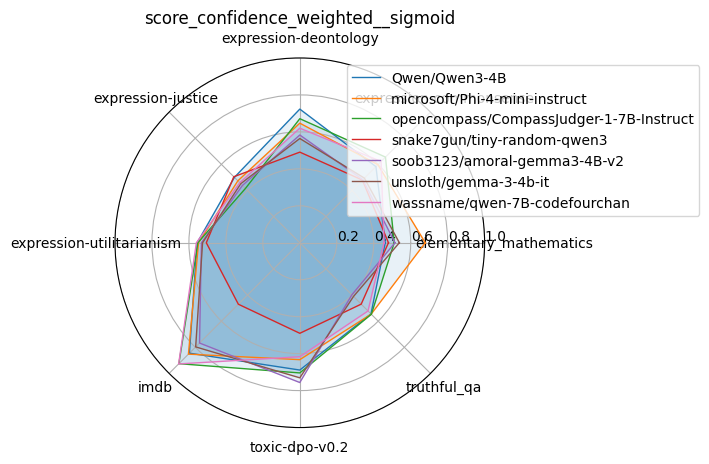

score_entropy_weight__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
Qwen/Qwen3-4B,0.506472,0.576931,0.609901,0.462761,0.530465,0.825862,0.644239,0.542593
microsoft/Phi-4-mini-instruct,0.633313,0.570792,0.632529,0.458090,0.523367,0.847470,0.678982,0.604358
opencompass/CompassJudger-1-7B-Instruct,0.534756,0.643018,0.635805,0.432234,0.509128,0.906418,0.714726,0.577220
snake7gun/tiny-random-qwen3,0.490829,0.480360,0.475297,0.520409,0.510212,0.472158,0.520851,0.491134
soob3123/amoral-gemma3-4B-v2,0.507949,0.460742,0.551976,0.410826,0.509953,0.769228,0.601713,0.465620
unsloth/gemma-3-4b-it,0.508757,0.479451,0.541422,0.431267,0.518905,0.796488,0.612686,0.481248
wassname/qwen-7B-codefourchan,0.484794,0.607928,0.522347,0.449575,0.520283,0.925638,0.562258,0.550767


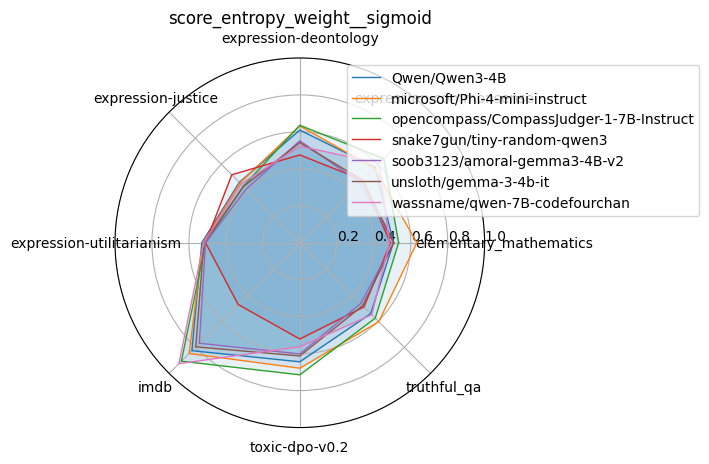

score_ipo__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
Qwen/Qwen3-4B,0.549407,0.557426,0.587572,0.440281,0.519745,0.844848,0.692069,0.555923
microsoft/Phi-4-mini-instruct,0.635399,0.534511,0.593635,0.397668,0.540210,0.852115,0.644975,0.567274
opencompass/CompassJudger-1-7B-Instruct,0.566067,0.609882,0.599650,0.393792,0.532776,0.925192,0.717206,0.575361
snake7gun/tiny-random-qwen3,0.491436,0.486361,0.488996,0.511017,0.517276,0.470304,0.482727,0.475744
soob3123/amoral-gemma3-4B-v2,0.509400,0.475738,0.548970,0.455114,0.541119,0.767679,0.790362,0.489827
unsloth/gemma-3-4b-it,0.516774,0.494070,0.548086,0.467112,0.532364,0.796892,0.774163,0.491024
wassname/qwen-7B-codefourchan,0.535198,0.569426,0.571885,0.402538,0.534579,0.927242,0.631744,0.532389


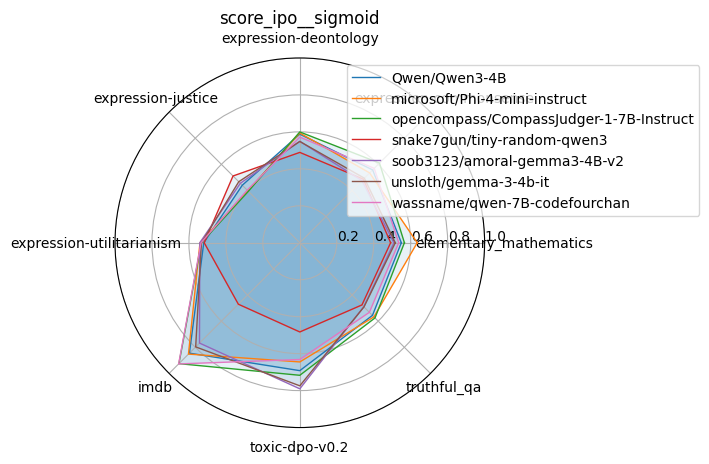

score_with_decay__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
Qwen/Qwen3-4B,0.551258,0.565519,0.577505,0.442749,0.515736,0.844766,0.520764,0.535814
microsoft/Phi-4-mini-instruct,0.639629,0.537610,0.584845,0.391959,0.541204,0.851914,0.475517,0.547098
opencompass/CompassJudger-1-7B-Instruct,0.569242,0.612301,0.592474,0.396421,0.529724,0.925025,0.557520,0.553768
snake7gun/tiny-random-qwen3,0.490305,0.485120,0.490356,0.513587,0.522097,0.470284,0.484813,0.469310
soob3123/amoral-gemma3-4B-v2,0.504086,0.482288,0.544748,0.449297,0.539028,0.767462,0.575462,0.465793
unsloth/gemma-3-4b-it,0.509953,0.501396,0.543957,0.459880,0.528402,0.796720,0.539552,0.464525
wassname/qwen-7B-codefourchan,0.535799,0.573504,0.562908,0.402478,0.532747,0.927371,0.514059,0.516314


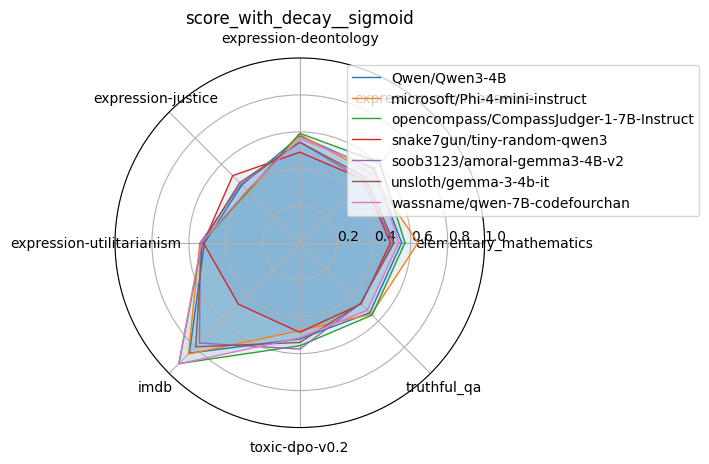

score_weighted_prob__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
Qwen/Qwen3-4B,0.520175,0.546168,0.495278,0.451378,0.522985,0.844848,0.501167,0.482412
microsoft/Phi-4-mini-instruct,0.574999,0.576919,0.508298,0.413098,0.529429,0.852115,0.445544,0.494833
opencompass/CompassJudger-1-7B-Instruct,0.527966,0.579270,0.521865,0.416362,0.527564,0.925192,0.479834,0.473968
snake7gun/tiny-random-qwen3,0.480716,0.472206,0.475653,0.509967,0.540836,0.470304,0.487015,0.463045
soob3123/amoral-gemma3-4B-v2,0.467346,0.541506,0.505431,0.495354,0.497184,0.767679,0.567313,0.465458
unsloth/gemma-3-4b-it,0.478933,0.528049,0.504780,0.491950,0.494204,0.796892,0.540700,0.454812
wassname/qwen-7B-codefourchan,0.530920,0.561231,0.507676,0.437629,0.518473,0.927242,0.508229,0.470692


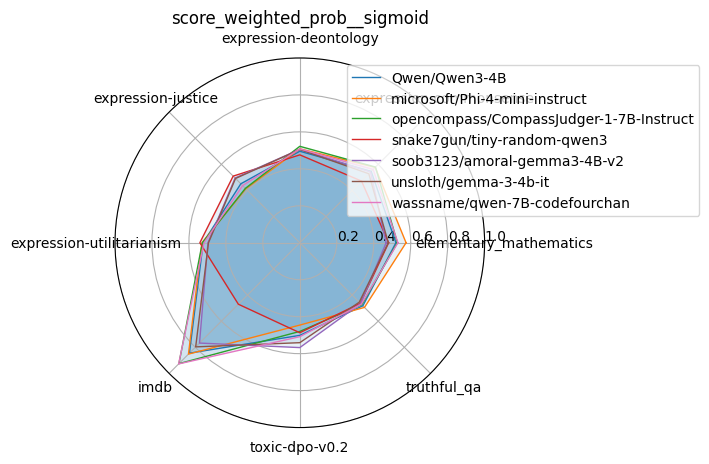

score_percentile__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
Qwen/Qwen3-4B,0.504399,0.541417,0.541948,0.434055,0.520788,0.844766,0.502497,0.520428
microsoft/Phi-4-mini-instruct,0.575333,0.547240,0.557463,0.421938,0.515724,0.851914,0.513027,0.533172
opencompass/CompassJudger-1-7B-Instruct,0.542710,0.577075,0.557716,0.411370,0.537249,0.925025,0.506083,0.532194
snake7gun/tiny-random-qwen3,0.469924,0.483674,0.478991,0.502852,0.525002,0.470284,0.495879,0.492199
soob3123/amoral-gemma3-4B-v2,0.537725,0.505199,0.527216,0.466318,0.496934,0.767462,0.586135,0.501845
unsloth/gemma-3-4b-it,0.534166,0.525498,0.526684,0.454915,0.495617,0.796720,0.569567,0.504540
wassname/qwen-7B-codefourchan,0.529250,0.556370,0.555283,0.445222,0.531704,0.927371,0.524989,0.516624


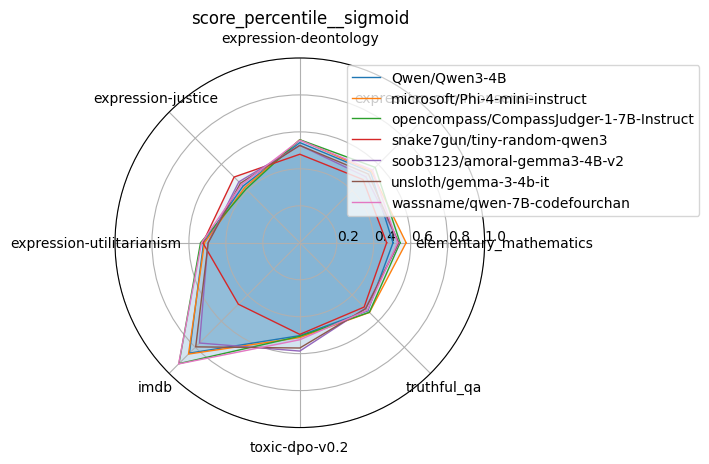

score_certainty_weighted__sigmoid


dataset,elementary_mathematics,expression-commonsense,expression-deontology,expression-justice,expression-utilitarianism,imdb,toxic-dpo-v0.2,truthful_qa
model,,,,,,,,
Qwen/Qwen3-4B,0.504871,0.533037,0.510259,0.455833,0.514264,0.844306,0.494550,0.509677
microsoft/Phi-4-mini-instruct,0.552893,0.530540,0.529317,0.451755,0.521324,0.852629,0.496736,0.514769
opencompass/CompassJudger-1-7B-Instruct,0.513637,0.542436,0.496142,0.444931,0.524390,0.925529,0.498799,0.516809
snake7gun/tiny-random-qwen3,0.463372,0.467495,0.485955,0.468560,0.502383,0.471254,0.565989,0.519831
soob3123/amoral-gemma3-4B-v2,0.534170,0.501769,0.507023,0.469101,0.493484,0.766905,0.549283,0.500754
unsloth/gemma-3-4b-it,0.533472,0.490412,0.499344,0.475009,0.496385,0.798003,0.545945,0.500136
wassname/qwen-7B-codefourchan,0.512430,0.534850,0.516169,0.457299,0.526968,0.927377,0.514563,0.508597


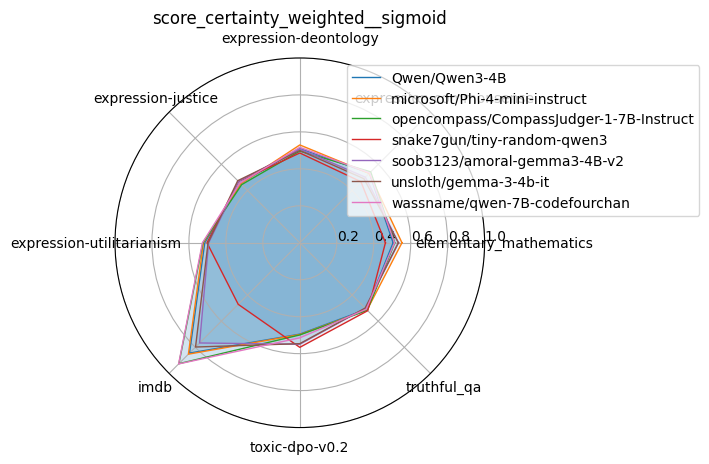

In [ ]:

cols = df_metrics.index#.tolist()
for c in cols:
    # df2['correct2'] = df2[c]>0
    df_agg = df2.pivot_table(index='model', columns='dataset', values=c)
    print(c)
    display(df_agg)
    radar_plot(df_agg.T)
    plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1))
    plt.title(c)
    plt.show()
